# Converting HCPh's physio into BIDS

This notebook shows how to convert from *AcqKnowledge* into BIDS.
First, let's import some necessary libraries.

In [1]:
%matplotlib inline

from pathlib import Path
from json import dumps
import string
import numpy as np
from scipy.signal import fftconvolve
from matplotlib import pyplot as plt
import pandas as pd

from bioread import read_file

plt.rcParams["figure.figsize"] = (20, 2.5)

In the file `schedule.tsv`, we will keep the lookup table of *AcqKnowledge* files generated and their corresponding session.
Some sessions (like 13) required restarting *AcqKnowledge* or some other issue and produced several *runs* as a consequence, we'll need to have special care with those.

In [2]:
biopac_lookup = pd.read_csv("schedule.tsv", sep='\t', na_values="n/a", dtype={"Run": "Int8"})
biopac_lookup

,session,day,PE,AcqKnowledge,Run
0,1,2023-10-20,LR,session2023-10-20T18:06:05.acq,<NA>
1,2,2023-10-20,LR,session2023-10-20T20:57:04.acq,<NA>
2,3,2023-10-21,LR,session2023-10-21T09:07:18.acq,<NA>
3,4,2023-10-21,RL,session2023-10-21T11:12:24.acq,<NA>
4,5,2023-10-22,PA,session2023-10-22T09:36:48.acq,<NA>
5,6,2023-10-22,PA,session2023-10-22T11:22:53.acq,<NA>
6,7,2023-10-23,LR,session2023-10-23T19:31:18.acq,<NA>
7,8,2023-10-23,RL,session2023-10-23T21:18:42.acq,<NA>
8,9,2023-10-24,AP,session2023-10-24T19:24:56.acq,<NA>
9,10,2023-10-24,RL,session2023-10-24T21:24:40.acq,<NA>


Now, let's set some constants and extract the corresponding *AcqKnowledge* file.
Update the `session` variable here to change what you are converting.

In [3]:
DATA_PATH = Path("/data/datasets/hcph-pilot-sourcedata/recordings/BIOPAC")
BIDS_PATH = Path("/data/datasets/hcph")
RECALIBRATED_SESSION = 23
FIRST_O2_SESSION = 11

participant = "001"
session = 20

biopac_session = biopac_lookup[biopac_lookup.session == session]

if len(biopac_session) != 1:
    raise RuntimeError

pe = biopac_session.PE.values[0]

Prepare repeated metadata across JSON files.
These JSON files may be consolidated at the top level of the BIDS structure for the most part.

In [4]:
CARD_JSON = {
    "Columns": ["ecg"],
    "Manufacturer": "BIOPAC Systems, Inc., Goleta, CA, US",
    "ecg": {
        "Description": "continuous measurements of Lead I electrocardiogram",
        "Units": "mV",
        "Model": "ECG100C MRI & MECMRI-2 amplifier",
    },
}

RESP_JSON = {
    "Columns": ["belt", "CO2", "O2"],
    "Manufacturer": "BIOPAC Systems, Inc., Goleta, CA, US",
    "belt": {
        "Description": "continuous breathing measurement by negative differential pressure with a respiration belt",
        "Units": "cm H20",
        "Model": "DA100C TSD160A transducer",
    },
    "CO2": {
        "Description": "continuous breathing measurement: absolute CO2 concentration",
        "Units": "%",
        "Model": "ML206",
        "Manufacturer": "AD Instruments Pty. Ltd., Sydney, Australia"
    },
    "O2": {
        "Description": "continuous breathing measurement: absolute O2 concentration",
        "Units": "%",
        "Model": "ML206",
        "Manufacturer": "AD Instruments Pty. Ltd., Sydney, Australia"
    }
}

if session < FIRST_O2_SESSION:
    RESP_JSON.pop("O2", None)
    RESP_JSON["Columns"].remove("O2")

We use the `bioread` package to load in the *AcqKnowledge* files.

In [5]:
session_data = read_file(str(DATA_PATH / biopac_session.AcqKnowledge.values[0]))
channels = session_data.channels

Now, let's peek into the data.
First, we check the frequency is 5 kHz.
Then, we visualize the trigger channel and extract the onset location.

In [6]:
freq = session_data.channels[4].samples_per_second
timeseries = session_data.channels[4].time_index

freq, len(timeseries)

(5000.0, 26344002)

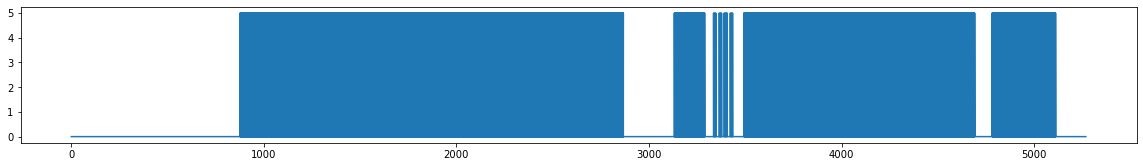

In [7]:
plt.plot(timeseries, session_data.channels[4].data);

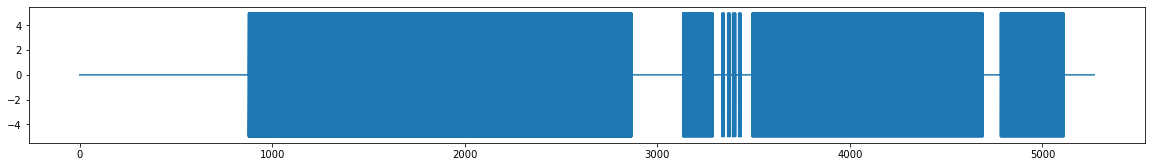

In [8]:
data = session_data.channels[4].data

trigger_events = np.hstack((0, np.diff(data)))
plt.plot(timeseries, trigger_events)

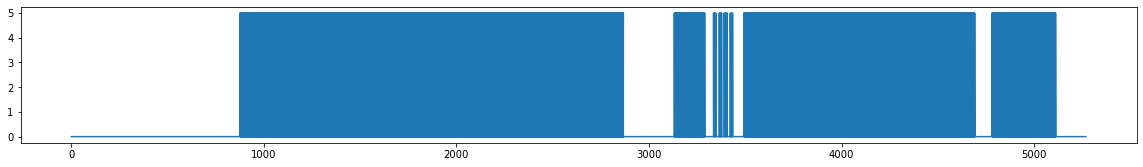

In [9]:
trigger_onsets = trigger_events.copy()
trigger_onsets[trigger_onsets < 0] = 0
plt.plot(timeseries, trigger_onsets)

Let's extract the onset of each run.
The following cell should show a **number 4** as the output.
If it is higher, manually delete onsets by index.
If it is lower, do not delete onsets and check because this could be a **partial** file.

In [11]:
trigger_locations = np.hstack((0, np.argwhere(trigger_onsets > 0)[:, 0]))
trigger_spacings = np.diff(trigger_locations)

# 120s is 2m (the shortest task, QCT)
between_seq = trigger_locations[1:][trigger_spacings > freq * 20]
# between_seq = np.delete(between_seq, (2, 3))
between_seq = np.delete(between_seq, 2)
seq_limits = np.zeros_like(trigger_onsets)
seq_limits[between_seq] = 1
print(len(between_seq))

4


If the correct triggers are preserved, the plot below should show an orange trigger at the beginning of the blocks we are interested in (DWI, QCT, rest, BHT).

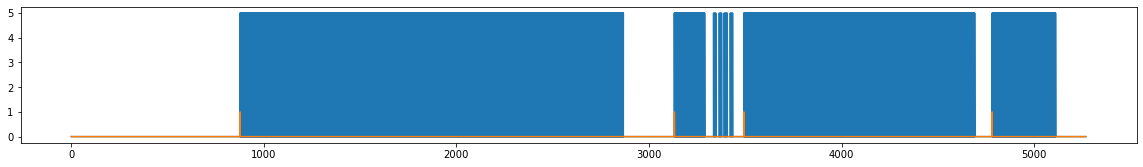

In [12]:
plt.plot(timeseries, trigger_onsets);
plt.plot(timeseries, seq_limits);

In [13]:
seq_onsets = [timeseries[i] for i in between_seq]
seq_onsets

[876.5474332731311, 3131.9963188884026, 3492.677932579626, 4781.819381514539]

## Converting physio corresponding to the DWI run of session 1

Cardiac signal (ECG) is stored in channel 2 of our *AcqKnowledge* files (i.e., index 1 in Python, which is zero-based).

First, let's calculate in the particular ECG channel, the indexes at which we are going to clip the cardiac signal around each imaging run.

For DWI, we will clip the files between `dwi_idx_start` and `dwi_idx_stop`.
In this case, for DWI we need to take into account that the sequence sends triggers during calibration (2 x 87 slices single slice mode, plus 29 for one multi-slice volume).
With this information, we will be able to calculate `dwi_onset` as the timepoint (in seconds) when the DWI sequence started acquiring the first final volume.

In [14]:
dummies = 87 * 2 + 29

first_trigger = trigger_locations[np.argwhere(trigger_locations == between_seq[0])[0, 0] + dummies]
t_0 = timeseries[first_trigger]

first_timepoint = int(between_seq[0] - 600 * freq)
t_start = timeseries[first_timepoint]

last_timepoint = between_seq[1]
t_stop = timeseries[last_timepoint]

Because DWI and trigger have both the same sampling frequency, this below could be simpler, but let's keep it to apply it later with other signals with different frequency.
Basically, we convert trigger indexes to time, and then, using the *timeseries* of the particular channel, we find the *what that trigger index would be, had the trigger timeseries been acquired at this other channel frequency instead*.

In [15]:
ch_index = 1
channels = session_data.channels
ch_freq = channels[ch_index].samples_per_second
ch_timeseries = channels[ch_index].time_index
ch_data = channels[ch_index].data

dwi_onset = ch_timeseries[(np.abs(ch_timeseries - t_0)).argmin()]
dwi_idx_start = (np.abs(ch_timeseries - t_start)).argmin()
dwi_idx_stop = (np.abs(ch_timeseries - t_stop)).argmin()

x_sec = ch_timeseries[dwi_idx_start:dwi_idx_stop] - dwi_onset
dwi_ch_data = ch_data[dwi_idx_start:dwi_idx_stop]
dwi_trigger = data[first_timepoint:last_timepoint]
dwi_idx_start, dwi_idx_stop, dwi_onset, x_sec[0], x_sec[-1], len(x_sec)

(1382737,
 15659981,
 907.034634430404,
 -630.4872239328565,
 2224.961484457991,
 14277244)

Let's now plot the ECG (blue) and trigger (orange) at the beginning of the DWI (at $t=0$).
It is clear how the ECG signal has been collected for a long while before the DWI, and then, at about 30 sec before the DWI first orientation onset, we see how the triggers corresponding to each slice of calibration kick in.
There are 2 volumes $\times$ 87 slices/volume (total 174 onsets) that are very fast at the beginning, followed by 29 triggers at a lower rate (one "dummy" or reference volume, acquired with the same SMS factor 3 of the rest of the DWI).

(-40.0, 1.0)

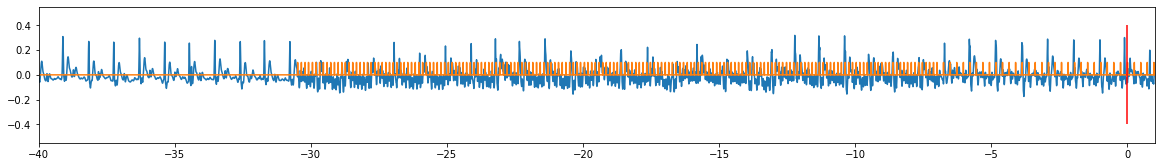

In [16]:
plt.plot(x_sec, dwi_ch_data)
plt.plot(x_sec, dwi_trigger / 50)
plt.vlines(0, -0.4, 0.4, colors="r")
plt.xlim((-40, 1))

In [17]:
dwi_cardio_filepath = BIDS_PATH / f"sub-{participant}" / f"ses-{session:03d}" / "dwi" / f"sub-{participant}_ses-{session:03d}_acq-highres_dir-{pe}_recording-cardiac_physio.tsv.gz"
dwi_sidecar = CARD_JSON.copy()
dwi_sidecar.update({
    "SamplingFrequency": ch_freq,
    "StartTime": x_sec[0],
})
(dwi_cardio_filepath.parent / dwi_cardio_filepath.name.replace(".tsv.gz", ".json")).write_text(dumps(dwi_sidecar, indent=2))

pd.DataFrame({"ecg": dwi_ch_data}).to_csv(
    dwi_cardio_filepath,
    compression="gzip",
    header=False,
    sep="\t",
    na_rep="n/a",
)

Let's move on to the respiration belt.

In [18]:
dwi_resp_data = {}

ch_freq = channels[0].samples_per_second
ch_timeseries = channels[0].time_index
ch_data = channels[0].data

dwi_onset = ch_timeseries[(np.abs(ch_timeseries - t_0)).argmin()]
dwi_idx_start = (np.abs(ch_timeseries - t_start)).argmin()
dwi_idx_stop = (np.abs(ch_timeseries - t_stop)).argmin()

x_sec = ch_timeseries[dwi_idx_start:dwi_idx_stop] - dwi_onset
dwi_resp_data["belt"] = ch_data[dwi_idx_start:dwi_idx_stop]

assert channels[2].samples_per_second == ch_freq
assert channels[3].samples_per_second == ch_freq

dwi_resp_data["CO2"] = channels[2].data[dwi_idx_start:dwi_idx_stop]
dwi_resp_data["O2"] = channels[3].data[dwi_idx_start:dwi_idx_stop]

if session < RECALIBRATED_SESSION:  # Before session 23, calibration was a bit off
    dwi_resp_data["CO2"] = dwi_resp_data["CO2"] * (8.0 - 0.045)  / 0.8 + 0.045
    dwi_resp_data["O2"] = (dwi_resp_data["O2"] - 0.1) * 10.946 / (20.946 + 0.1) + 10

(-40.0, 1.0)

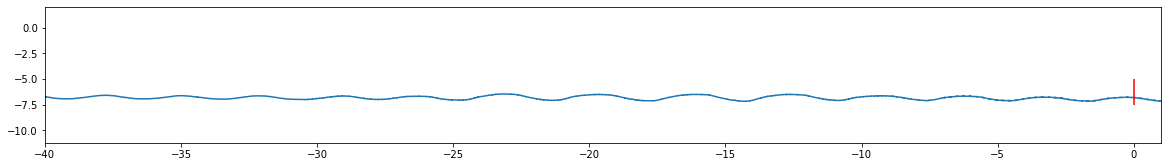

In [19]:
plt.plot(x_sec, dwi_resp_data["belt"])
plt.vlines(0, -7.5, -5, colors="r")
plt.xlim((-40, 1))

(-40.0, 1.0)

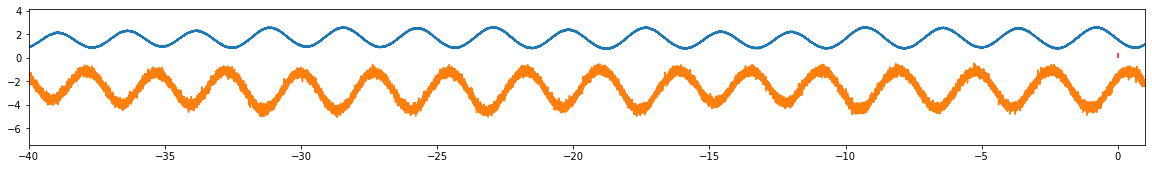

In [20]:
plt.plot(x_sec, dwi_resp_data["CO2"])
plt.plot(x_sec, dwi_resp_data["O2"] - 20.946)
plt.vlines(0, 0, 0.4, colors="r")
plt.xlim((-40, 1))

In [21]:
dwi_resp_filepath = BIDS_PATH / f"sub-{participant}" / f"ses-{session:03d}" / "dwi" / f"sub-{participant}_ses-{session:03d}_acq-highres_dir-{pe}_recording-respiratory_physio.tsv.gz"
dwi_sidecar = RESP_JSON.copy()
dwi_sidecar.update({
    "SamplingFrequency": ch_freq,
    "StartTime": x_sec[0],
})

(dwi_resp_filepath.parent / dwi_resp_filepath.name.replace(".tsv.gz", ".json")).write_text(dumps(dwi_sidecar, indent=2))

pd.DataFrame(dwi_resp_data).to_csv(
    dwi_resp_filepath,
    compression="gzip",
    header=False,
    sep="\t",
    na_rep="n/a",
)

Finally, let's write all digital signals in a third file:

In [22]:
dwi_triggers_filepath = BIDS_PATH / f"sub-{participant}" / f"ses-{session:03d}" / "dwi" / f"sub-{participant}_ses-{session:03d}_acq-highres_dir-{pe}_stim.tsv.gz"

channel_idx = list(range(4, len(channels)))

columns = ["trigger"] + [f"digital_ch{line}" for line in range(5, len(channels))]

dwi_trigger_data = {
    name: channels[ch_i].data[first_timepoint:last_timepoint]
    for name, ch_i in zip(columns, channel_idx)
}

dwi_sidecar = {
    "SamplingFrequency": channels[4].samples_per_second,
    "StartTime": t_start - t_0,
    "Columns": columns,
    "Manufacturer": "BIOPAC Systems, Inc., Goleta, CA, US",
}

for col, chid in zip(columns, channel_idx):
    dwi_sidecar[col] = {
        "Description": f"{''.join(filter(lambda x: x in string.printable, session_data.channel_headers[chid]['szCommentText'].decode().strip()))}: digital pulse signal generated with Psychopy",
        "Units": "V",
        "Model": "SPT100D",
    }
dwi_sidecar["trigger"]["Description"] = "continuous measurement of the scanner trigger signal"

(dwi_triggers_filepath.parent / dwi_triggers_filepath.name.replace(".tsv.gz", ".json")).write_text(dumps(dwi_sidecar, indent=2))


pd.DataFrame(dwi_trigger_data).to_csv(
    dwi_triggers_filepath,
    compression="gzip",
    header=False,
    sep="\t",
    na_rep="n/a",
)

## Converting the physio corresponding to BHT  into BIDS

In [23]:
dummies = 0

first_trigger = trigger_locations[np.argwhere(trigger_locations == between_seq[-1])[0, 0] + dummies]
t_0 = timeseries[first_trigger]

first_timepoint = int(between_seq[-1] - 120 * freq)
t_start = timeseries[first_timepoint]

last_timepoint = len(timeseries) - 1
t_stop = timeseries[last_timepoint]

In [24]:
ch_index = 1
channels = session_data.channels
ch_freq = channels[ch_index].samples_per_second
ch_timeseries = channels[ch_index].time_index
ch_data = channels[ch_index].data

bht_onset = ch_timeseries[(np.abs(ch_timeseries - t_0)).argmin()]
bht_idx_start = (np.abs(ch_timeseries - t_start)).argmin()
bht_idx_stop = (np.abs(ch_timeseries - t_stop)).argmin()

x_sec = ch_timeseries[bht_idx_start:bht_idx_stop] - bht_onset
bht_ch_data = ch_data[bht_idx_start:bht_idx_stop]
bht_trigger = data[first_timepoint:last_timepoint]
bht_idx_start, bht_idx_stop, bht_onset, x_sec[0], x_sec[-1], len(x_sec)

(23309096,
 26344001,
 4781.819381514539,
 -120.00000455511599,
 486.9808184854537,
 3034905)

(-5.0, 10.0)

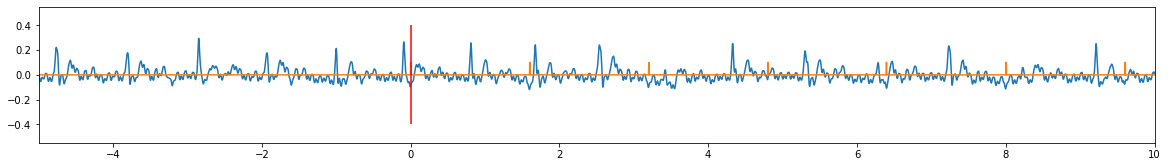

In [25]:
plt.plot(x_sec, bht_ch_data)
plt.plot(x_sec, bht_trigger / 50)
plt.vlines(0, -0.4, 0.4, colors="r")
plt.xlim((-5, 10))

In [26]:
bht_cardio_filepath = BIDS_PATH / f"sub-{participant}" / f"ses-{session:03d}" / "func" / f"sub-{participant}_ses-{session:03d}_task-bht_dir-{pe}_recording-cardiac_physio.tsv.gz"
bht_sidecar = CARD_JSON.copy()
bht_sidecar.update({
    "SamplingFrequency": ch_freq,
    "StartTime": x_sec[0],
})
(bht_cardio_filepath.parent / bht_cardio_filepath.name.replace(".tsv.gz", ".json")).write_text(dumps(bht_sidecar, indent=2))

pd.DataFrame({"ecg": bht_ch_data}).to_csv(
    bht_cardio_filepath,
    compression="gzip",
    header=False,
    sep="\t",
    na_rep="n/a",
)

In [27]:
bht_resp_data = {}

ch_index = 0
ch_freq = channels[ch_index].samples_per_second
ch_timeseries = channels[ch_index].time_index
ch_data = channels[ch_index].data

bht_onset = ch_timeseries[(np.abs(ch_timeseries - t_0)).argmin()]
bht_idx_start = (np.abs(ch_timeseries - t_start)).argmin()
bht_idx_stop = (np.abs(ch_timeseries - t_stop)).argmin()

x_sec = ch_timeseries[bht_idx_start:bht_idx_stop] - bht_onset
bht_resp_data["belt"] = ch_data[bht_idx_start:bht_idx_stop]

assert channels[2].samples_per_second == ch_freq
assert channels[3].samples_per_second == ch_freq

bht_resp_data["CO2"] = channels[2].data[bht_idx_start:bht_idx_stop]
bht_resp_data["O2"] = channels[3].data[bht_idx_start:bht_idx_stop]

if session < RECALIBRATED_SESSION:  # Before session 23, calibration was a bit off
    bht_resp_data["CO2"] = bht_resp_data["CO2"] * (8.0 - 0.045)  / 0.8 + 0.045
    bht_resp_data["O2"] = (bht_resp_data["O2"] - 0.1) * 10.946 / (20.946 + 0.1) + 10

(0.0, 4.0)

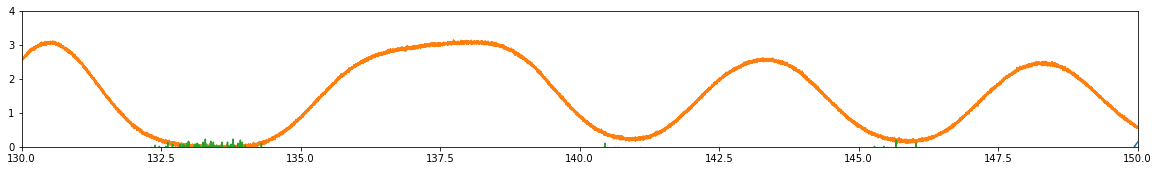

In [28]:
plt.plot(x_sec, bht_resp_data["belt"])
plt.plot(x_sec, bht_resp_data["CO2"])
plt.plot(x_sec, bht_resp_data["O2"] - 21)
plt.xlim((130, 150))
plt.ylim((0, 4))

In [29]:
bht_resp_filepath = BIDS_PATH / f"sub-{participant}" / f"ses-{session:03d}" / "func" / f"sub-{participant}_ses-{session:03d}_task-bht_dir-{pe}_recording-respiratory_physio.tsv.gz"
bht_sidecar = RESP_JSON.copy()
bht_sidecar.update({
    "SamplingFrequency": ch_freq,
    "StartTime": x_sec[0],
})

(bht_resp_filepath.parent / bht_resp_filepath.name.replace(".tsv.gz", ".json")).write_text(dumps(bht_sidecar, indent=2))

pd.DataFrame(bht_resp_data).to_csv(
    bht_resp_filepath,
    compression="gzip",
    header=False,
    sep="\t",
    na_rep="n/a",
)

In [30]:
bht_trigg_filepath = BIDS_PATH / f"sub-{participant}" / f"ses-{session:03d}" / "func" / f"sub-{participant}_ses-{session:03d}_task-bht_dir-{pe}_stim.tsv.gz"

channel_idx = list(range(4, len(channels)))

columns = ["trigger"] + [f"digital_ch{line}" for line in range(5, len(channels))]

bht_sidecar = {
    "SamplingFrequency": channels[4].samples_per_second,
    "StartTime": t_start - t_0,
    "Columns": columns,
    "Manufacturer": "BIOPAC Systems, Inc., Goleta, CA, US",
}

for col, chid in zip(columns, channel_idx):
    bht_sidecar[col] = {
        "Description": f"{''.join(filter(lambda x: x in string.printable, session_data.channel_headers[chid]['szCommentText'].decode().strip()))}: digital pulse signal generated with Psychopy",
        "Units": "V",
        "Model": "SPT100D",
    }
bht_sidecar["trigger"]["Description"] = "continuous measurement of the scanner trigger signal"

(bht_trigg_filepath.parent / bht_trigg_filepath.name.replace(".tsv.gz", ".json")).write_text(dumps(bht_sidecar, indent=2))

bht_trigger_data = {
    name: channels[ch_i].data[first_timepoint:last_timepoint]
    for name, ch_i in zip(columns, channel_idx)
}

pd.DataFrame(bht_trigger_data).to_csv(
    bht_trigg_filepath,
    compression="gzip",
    header=False,
    sep="\t",
    na_rep="n/a",
)

## Converting the physio corresponding to RSfMRI  into BIDS

In [31]:
dummies = 0

first_trigger = trigger_locations[np.argwhere(trigger_locations == between_seq[-2])[0, 0] + dummies]
t_0 = timeseries[first_trigger]

first_timepoint = int(between_seq[-2] - 120 * freq)
t_start = timeseries[first_timepoint]

last_timepoint = between_seq[-1]
t_stop = timeseries[last_timepoint]

In [32]:
ch_index = 1
channels = session_data.channels
ch_freq = channels[ch_index].samples_per_second
ch_timeseries = channels[ch_index].time_index
ch_data = channels[ch_index].data

rest_onset = ch_timeseries[(np.abs(ch_timeseries - t_0)).argmin()]
rest_idx_start = (np.abs(ch_timeseries - t_start)).argmin()
rest_idx_stop = (np.abs(ch_timeseries - t_stop)).argmin()

x_sec = ch_timeseries[rest_idx_start:rest_idx_stop] - rest_onset
rest_ch_data = ch_data[rest_idx_start:rest_idx_stop]
rest_trigger = data[first_timepoint:last_timepoint]
rest_idx_start, rest_idx_stop, rest_onset, x_sec[0], x_sec[-1], len(x_sec)

(16863389,
 23909096,
 3492.677932579626,
 -120.0000045551169,
 1289.141248934905,
 7045707)

(-5.0, 10.0)

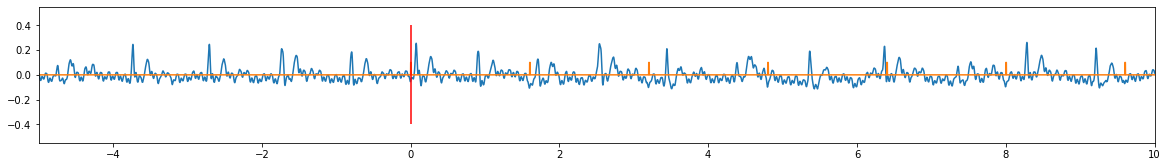

In [33]:
plt.plot(x_sec, rest_ch_data)
plt.plot(x_sec, rest_trigger / 50)
plt.vlines(0, -0.4, 0.4, colors="r")
plt.xlim((-5, 10))

In [34]:
rest_cardio_filepath = BIDS_PATH / f"sub-{participant}" / f"ses-{session:03d}" / "func" / f"sub-{participant}_ses-{session:03d}_task-rest_dir-{pe}_recording-cardiac_physio.tsv.gz"
rest_sidecar = CARD_JSON.copy()
rest_sidecar.update({
    "SamplingFrequency": ch_freq,
    "StartTime": x_sec[0],
})
(rest_cardio_filepath.parent / rest_cardio_filepath.name.replace(".tsv.gz", ".json")).write_text(dumps(rest_sidecar, indent=2))

pd.DataFrame({"ecg": rest_ch_data}).to_csv(
    rest_cardio_filepath,
    compression="gzip",
    header=False,
    sep="\t",
    na_rep="n/a",
)

In [35]:
rest_resp_data = {}

ch_index = 0
ch_freq = channels[ch_index].samples_per_second
ch_timeseries = channels[ch_index].time_index
ch_data = channels[ch_index].data

rest_onset = ch_timeseries[(np.abs(ch_timeseries - t_0)).argmin()]
rest_idx_start = (np.abs(ch_timeseries - t_start)).argmin()
rest_idx_stop = (np.abs(ch_timeseries - t_stop)).argmin()

x_sec = ch_timeseries[rest_idx_start:rest_idx_stop] - rest_onset
rest_resp_data["belt"] = ch_data[rest_idx_start:rest_idx_stop]

assert channels[2].samples_per_second == ch_freq
assert channels[3].samples_per_second == ch_freq

rest_resp_data["CO2"] = channels[2].data[rest_idx_start:rest_idx_stop]
rest_resp_data["O2"] = channels[3].data[rest_idx_start:rest_idx_stop]

if session < RECALIBRATED_SESSION:  # Before session 23, calibration was a bit off
    rest_resp_data["CO2"] = rest_resp_data["CO2"] * (8.0 - 0.045)  / 0.8 + 0.045
    rest_resp_data["O2"] = (rest_resp_data["O2"] - 0.1) * 10.946 / (20.946 + 0.1) + 10

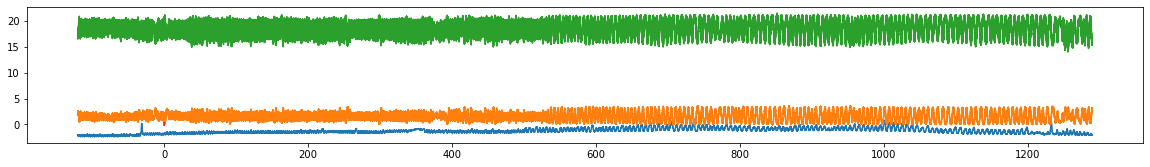

In [36]:
plt.plot(x_sec, rest_resp_data["belt"])
plt.plot(x_sec, rest_resp_data["CO2"])
plt.plot(x_sec, rest_resp_data["O2"])

plt.vlines(0, -0.4, 0.4, colors="r")

In [37]:
rest_resp_filepath = BIDS_PATH / f"sub-{participant}" / f"ses-{session:03d}" / "func" / f"sub-{participant}_ses-{session:03d}_task-rest_dir-{pe}_recording-respiratory_physio.tsv.gz"
rest_sidecar = RESP_JSON.copy()
rest_sidecar.update({
    "SamplingFrequency": ch_freq,
    "StartTime": x_sec[0],
})

(rest_resp_filepath.parent / rest_resp_filepath.name.replace(".tsv.gz", ".json")).write_text(dumps(rest_sidecar, indent=2))

pd.DataFrame(rest_resp_data).to_csv(
    rest_resp_filepath,
    compression="gzip",
    header=False,
    sep="\t",
    na_rep="n/a",
)

In [38]:
rest_trigg_filepath = BIDS_PATH / f"sub-{participant}" / f"ses-{session:03d}" / "func" / f"sub-{participant}_ses-{session:03d}_task-rest_dir-{pe}_stim.tsv.gz"

channel_idx = list(range(4, len(channels)))

columns = ["trigger"] + [f"digital_ch{line}" for line in range(5, len(channels))]

rest_sidecar = {
    "SamplingFrequency": channels[4].samples_per_second,
    "StartTime": t_start - t_0,
    "Columns": columns,
    "Manufacturer": "BIOPAC Systems, Inc., Goleta, CA, US",
}

for col, chid in zip(columns, channel_idx):
    rest_sidecar[col] = {
        "Description": f"{''.join(filter(lambda x: x in string.printable, session_data.channel_headers[chid]['szCommentText'].decode().strip()))}: digital pulse signal generated with Psychopy",
        "Units": "V",
        "Model": "SPT100D",
    }
rest_sidecar["trigger"]["Description"] = "continuous measurement of the scanner trigger signal"

(rest_trigg_filepath.parent / rest_trigg_filepath.name.replace(".tsv.gz", ".json")).write_text(dumps(rest_sidecar, indent=2))

rest_trigger_data = {
    name: channels[ch_i].data[first_timepoint:last_timepoint]
    for name, ch_i in zip(columns, channel_idx)
}

pd.DataFrame(rest_trigger_data).to_csv(
    rest_trigg_filepath,
    compression="gzip",
    header=False,
    sep="\t",
    na_rep="n/a",
)

## Converting the physio corresponding to QCT  into BIDS

In [39]:
dummies = 0

first_trigger = trigger_locations[np.argwhere(trigger_locations == between_seq[-3])[0, 0] + dummies]
t_0 = timeseries[first_trigger]

first_timepoint = int(between_seq[-3] - 120 * freq)
t_start = timeseries[first_timepoint]

last_timepoint = between_seq[-2]
t_stop = timeseries[last_timepoint]

(-5.0, 10.0)

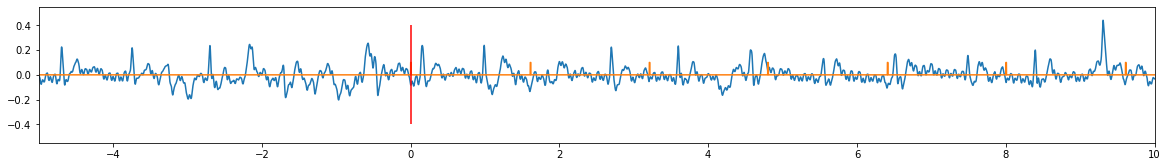

In [40]:
ch_index = 1
channels = session_data.channels
ch_freq = channels[ch_index].samples_per_second
ch_timeseries = channels[ch_index].time_index
ch_data = channels[ch_index].data

qct_onset = ch_timeseries[(np.abs(ch_timeseries - t_0)).argmin()]
qct_idx_start = (np.abs(ch_timeseries - t_start)).argmin()
qct_idx_stop = (np.abs(ch_timeseries - t_stop)).argmin()

x_sec = ch_timeseries[qct_idx_start:qct_idx_stop] - qct_onset
qct_ch_data = ch_data[qct_idx_start:qct_idx_stop]
qct_trigger = data[first_timepoint:last_timepoint]

# plot it
plt.plot(x_sec, qct_ch_data)
plt.plot(x_sec, qct_trigger / 50)
plt.vlines(0, -0.4, 0.4, colors="r")
plt.xlim((-5, 10))

In [41]:
qct_cardio_filepath = BIDS_PATH / f"sub-{participant}" / f"ses-{session:03d}" / "func" / f"sub-{participant}_ses-{session:03d}_task-qct_dir-{pe}_recording-cardiac_physio.tsv.gz"
qct_sidecar = CARD_JSON.copy()
qct_sidecar.update({
    "SamplingFrequency": ch_freq,
    "StartTime": x_sec[0],
})
(qct_cardio_filepath.parent / qct_cardio_filepath.name.replace(".tsv.gz", ".json")).write_text(dumps(qct_sidecar, indent=2))

pd.DataFrame({"ecg": qct_ch_data}).to_csv(
    qct_cardio_filepath,
    compression="gzip",
    header=False,
    sep="\t",
    na_rep="n/a",
)

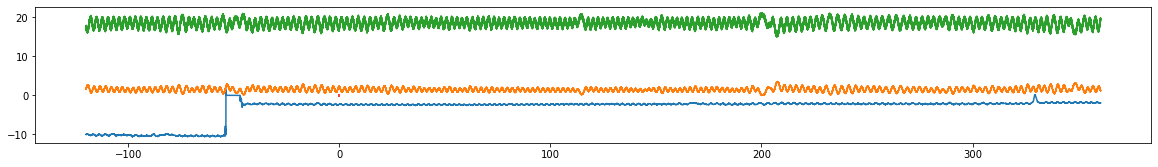

In [42]:
qct_resp_data = {}

ch_index = 0
ch_freq = channels[ch_index].samples_per_second
ch_timeseries = channels[ch_index].time_index
ch_data = channels[ch_index].data

qct_onset = ch_timeseries[(np.abs(ch_timeseries - t_0)).argmin()]
qct_idx_start = (np.abs(ch_timeseries - t_start)).argmin()
qct_idx_stop = (np.abs(ch_timeseries - t_stop)).argmin()

x_sec = ch_timeseries[qct_idx_start:qct_idx_stop] - qct_onset
qct_resp_data["belt"] = ch_data[qct_idx_start:qct_idx_stop]

assert channels[2].samples_per_second == ch_freq
assert channels[3].samples_per_second == ch_freq

qct_resp_data["CO2"] = channels[2].data[qct_idx_start:qct_idx_stop]
qct_resp_data["O2"] = channels[3].data[qct_idx_start:qct_idx_stop]

if session < RECALIBRATED_SESSION:  # Before session 23, calibration was a bit off
    qct_resp_data["CO2"] = qct_resp_data["CO2"] * (8.0 - 0.045)  / 0.8 + 0.045
    qct_resp_data["O2"] = (qct_resp_data["O2"] - 0.1) * 10.946 / (20.946 + 0.1) + 10

plt.plot(x_sec, qct_resp_data["belt"])
plt.plot(x_sec, qct_resp_data["CO2"])
plt.plot(x_sec, qct_resp_data["O2"])
plt.vlines(0, -0.4, 0.4, colors="r")

In [43]:
qct_resp_filepath = BIDS_PATH / f"sub-{participant}" / f"ses-{session:03d}" / "func" / f"sub-{participant}_ses-{session:03d}_task-qct_dir-{pe}_recording-respiratory_physio.tsv.gz"
qct_sidecar = RESP_JSON.copy()
qct_sidecar.update({
    "SamplingFrequency": ch_freq,
    "StartTime": x_sec[0],
})

(qct_resp_filepath.parent / qct_resp_filepath.name.replace(".tsv.gz", ".json")).write_text(dumps(qct_sidecar, indent=2))

pd.DataFrame(qct_resp_data).to_csv(
    qct_resp_filepath,
    compression="gzip",
    header=False,
    sep="\t",
    na_rep="n/a",
)

In [44]:
qct_trigg_filepath = BIDS_PATH / f"sub-{participant}" / f"ses-{session:03d}" / "func" / f"sub-{participant}_ses-{session:03d}_task-qct_dir-{pe}_stim.tsv.gz"

channel_idx = list(range(4, len(channels)))

columns = ["trigger"] + [f"digital_ch{line}" for line in range(5, len(channels))]

qct_sidecar = {
    "SamplingFrequency": channels[4].samples_per_second,
    "StartTime": t_start - t_0,
    "Columns": columns,
    "Manufacturer": "BIOPAC Systems, Inc., Goleta, CA, US",
}

for col, chid in zip(columns, channel_idx):
    qct_sidecar[col] = {
        "Description": f"{''.join(filter(lambda x: x in string.printable, session_data.channel_headers[chid]['szCommentText'].decode().strip()))}: digital pulse signal generated with Psychopy",
        "Units": "V",
        "Model": "SPT100D",
    }
qct_sidecar["trigger"]["Description"] = "continuous measurement of the scanner trigger signal"

(qct_trigg_filepath.parent / qct_trigg_filepath.name.replace(".tsv.gz", ".json")).write_text(dumps(qct_sidecar, indent=2))

qct_trigger_data = {
    name: channels[ch_i].data[first_timepoint:last_timepoint]
    for name, ch_i in zip(columns, channel_idx)
}

pd.DataFrame(qct_trigger_data).to_csv(
    qct_trigg_filepath,
    compression="gzip",
    header=False,
    sep="\t",
    na_rep="n/a",
)

## Scraps
Some code that could become interesting some day.

In [ ]:
n_trigg_dwi = 87 * 2 + 29 + 280 * 29

first_dwi = np.argwhere(trigger_locations == between_seq[0])[0, 0]
last_dwi = trigger_locations[first_dwi + n_trigg_dwi]

seq_limits[last_dwi + int(7 * freq)] = 1

plt.plot(timeseries, trigger_onsets);
plt.plot(timeseries, seq_limits);
plt.xlim((last_dwi / freq - 70, last_dwi / freq + 28))

In [ ]:
boxcar = np.ones(round(freq * (7 / 29)) + 5)
envelope = fftconvolve(trigger_locations, boxcar)
envelope = envelope[len(boxcar) // 2:-(len(boxcar) // 2 - 1 + len(boxcar) % 2)]
plt.plot(timeseries, envelope)

In [ ]:
env_copy = envelope.copy()
env_copy[env_copy < 10] = 0
env_copy[env_copy > 0] = 1

In [ ]:
plt.plot(timeseries, env_copy)

In [ ]:
from scipy.ndimage import binary_closing

In [ ]:
amplitude = binary_closing(trigger_locations, structure=np.ones(int(freq * 1.6)))
plt.plot(timeseries, amplitude)